In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision.models import vgg16
from HSI_class import HSI
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import zeroPadding

import torch.nn.functional as F
import time
start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size = 20
test_size = 0.5

random = 0

GPU Available: True
GPU Name: NVIDIA GeForce GTX 1650


In [2]:
dataset_path = r"C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>2:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: C:\Users\Asus TUF\Documents\code\TA\Hyperspectral oil spill detection datasets\GM03.mat


In [3]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
def predict_batch(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict continuous values ---
    predicted_values = model.predict(test_features_np)

    # --- Convert to class labels using threshold ---
    predicted_classes = (predicted_values >= 0.5).astype(int)

    # --- Clip predicted values to [0, 1] as pseudo-probabilities ---
    positive_probs = np.clip(predicted_values, 0, 1)


    return predicted_classes, positive_probs


In [7]:
import createSample as CS

hsi_ = datasets[0]
patch_size = 9


indices_0 = []
indices_1 = []

print(f"random: {random}")

if random:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
using generated indices
hsi shape
(1243, 684, 224)
indices 0 used: [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
indices 1 used: [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [8]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-207 -419  261  355  412  560  640  650  640  607  572  534  499  473
  439  410  385  367  348  320  295  273  255  230  209  195  185  173
  169  159  157  150  140  139  133  121  112  102  101   74   91   97
   95   80   94   94   86   81   85   74   79   82   89   85   86   80
   76   53   37   23   18  -64  -92  -57   29   40   53   69   77   83
   90   84   84   84   79   69   56   43   24  -14  -98 -107  -96 -115
  -21   11   23   29   39   40   50   62   66   64   68   70   71   72
   75   63   56   38   39   52    0  -36  -85    0    0    0    0    0
    0  -56  -47  -48  -86  -44  -62  -41    7   20   34   47   60   82
   70   74   67   72   72   77   70   75   75   79   74   69   70   74
   69   70   59   66   55   43   39   33   24   16    4  -20  -32    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   -9  -21   -3    0    7    3  -20    8   26   32   40   40   42   50
   53   55   51   58   55   50   55   57   54   54   50   52   53   55
   44 

In [9]:
import augmentation as aug
n_category = 2
band_size = 224


data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)



data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [10]:
class ConvTo1D(nn.Module):
    def __init__(self):
        super(ConvTo1D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=224, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # (batch_size, 128, 1, 1)
        self.flatten = nn.Flatten()               # (batch_size, 128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        return x

feature_extractor = ConvTo1D()

In [11]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")

feature_extractor = ConvTo1D()
with torch.no_grad():  # No gradient needed for feature extraction
    features = feature_extractor(x_data)  # (100, 128)
    features_np = features.numpy() 

    

print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 128)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=42)

print(y_train)
print(y_val)

[0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 1]
[1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1]


In [13]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# --- Train Logistic Regression ---
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline.fit(X_train, y_train)

# --- Predict probabilities for class 1 ---
positive_probs = pipeline.predict_proba(X_val)[:, 1]

# --- Convert probabilities to class labels using 0.5 threshold ---
predicted_classes = (positive_probs >= 0.5).astype(int)

# --- Display predictions with probabilities ---
for i, (pred, prob) in enumerate(zip(predicted_classes, positive_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")

# --- Accuracy ---
acc = accuracy_score(y_val, predicted_classes)
print(f"Validation Accuracy: {acc:.4f}")


Sample 0: Predicted = 1, Prob(class 1) = 0.9998
Sample 1: Predicted = 1, Prob(class 1) = 0.9998
Sample 2: Predicted = 1, Prob(class 1) = 0.9857
Sample 3: Predicted = 0, Prob(class 1) = 0.0038
Sample 4: Predicted = 0, Prob(class 1) = 0.0048
Sample 5: Predicted = 1, Prob(class 1) = 0.9855
Sample 6: Predicted = 1, Prob(class 1) = 0.9996
Sample 7: Predicted = 0, Prob(class 1) = 0.0032
Sample 8: Predicted = 1, Prob(class 1) = 0.9994
Sample 9: Predicted = 0, Prob(class 1) = 0.0030
Sample 10: Predicted = 0, Prob(class 1) = 0.0034
Sample 11: Predicted = 0, Prob(class 1) = 0.0031
Sample 12: Predicted = 1, Prob(class 1) = 0.9906
Sample 13: Predicted = 1, Prob(class 1) = 0.9963
Sample 14: Predicted = 1, Prob(class 1) = 0.9947
Sample 15: Predicted = 0, Prob(class 1) = 0.0032
Sample 16: Predicted = 1, Prob(class 1) = 1.0000
Sample 17: Predicted = 0, Prob(class 1) = 0.0055
Sample 18: Predicted = 0, Prob(class 1) = 0.0105
Sample 19: Predicted = 1, Prob(class 1) = 0.9568
Validation Accuracy: 1.0000


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

patch_size = 9
half_patch = patch_size // 2

scores = []
batch_size = 64
groundtruth = []
prediction = []
y_probs = []


for dataset in range(len(datasets)):
    print(f"tes: {dataset}")
    test_indices, test_gt, matrix = testWithDataset(dataset)

    total = len(test_indices)
    correct0 = 0
    correct1 = 0

    input_patches = []
    true_labels = []

    # Prepare all patches
    for x_pos, y_pos in test_indices:
        true_label = test_gt[x_pos][y_pos]

        selected_rows = matrix[x_pos:x_pos + 2*half_patch + 1, :]
        testing_patch = selected_rows[:, y_pos:y_pos + 2*half_patch + 1]

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.unsqueeze(0).permute(0, 3, 1, 2)

        input_patches.append(patch_tensor)
        true_labels.append(true_label)

    input_patches = torch.cat(input_patches, dim=0)  # Shape: (N, C, H, W)
    true_labels = torch.tensor(true_labels)

    # Process in batches
    for i in tqdm(range(0, total, batch_size), desc="Predicting"):
        batch = input_patches[i:i+batch_size]
        labels = true_labels[i:i+batch_size]

        groundtruth.append(labels)

        preds, postive_class_probs = predict_batch(pipeline, feature_extractor, batch, device)

        prediction.append(preds)
        y_probs.append(postive_class_probs)

        for j in range(len(preds)):
            index = i + j
            # print(f"{index+1}: prediction = {preds[j]}, expected: {labels[j].item()}")
            if preds[j] == labels[j].item():
                if labels[j].item() == 0:
                    correct0 += 1
                elif labels[j] == 1:
                    correct1 += 1

    correct = correct0 + correct1
    print(f"Score: {correct}/{total}")
    
    score = {
        'dataset': dataset,
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    scores.append(score)
    # scores.append((f"dataset{dataset}", f'{correct0}/{total/2}', f'{correct1}/{total/2}', f'{correct}/{total}'))

tes: 0
img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
(100, 2)


Predicting: 100%|██████████| 2/2 [00:00<00:00, 30.07it/s]

Score: 76/100
tes: 1


img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
(100, 2)


Predicting: 100%|██████████| 2/2 [00:00<00:00, 29.00it/s]


Score: 66/100
tes: 2
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
(100, 2)


Predicting: 100%|██████████| 2/2 [00:00<00:00, 38.15it/s]

Score: 90/100


In [15]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{total/2}\t', f'{correct1}/{total/2}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1


print(f"total: \t\t {all_correct0}/{all_total/2} \t {all_correct1}/{all_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

dataset: 0	 47/50.0	 29/50.0	 76/100	
dataset: 1	 16/50.0	 50/50.0	 66/100	
dataset: 2	 43/50.0	 47/50.0	 90/100	
total: 		 106/150.0 	 126/150.0 	 232/300
acc: 0.7733333333333333


In [16]:
groundtruths = groundtruth
groundtruth = []

for x in groundtruths:
    for y in x:
        groundtruth.append(y)

predictions = prediction
prediction = []

for x in predictions:
    for y in x:
        prediction.append(y)


y_prob = []

for x in y_probs:
    for y in x:
        y_prob.append(y)

In [17]:
print(len(groundtruth))
print(len(prediction))
print(len(y_prob))

300
300
300


In [18]:
y_test = groundtruth
y_pred = prediction
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [19]:
print(f'{correct}/{total}')

232/300


In [20]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(0)]


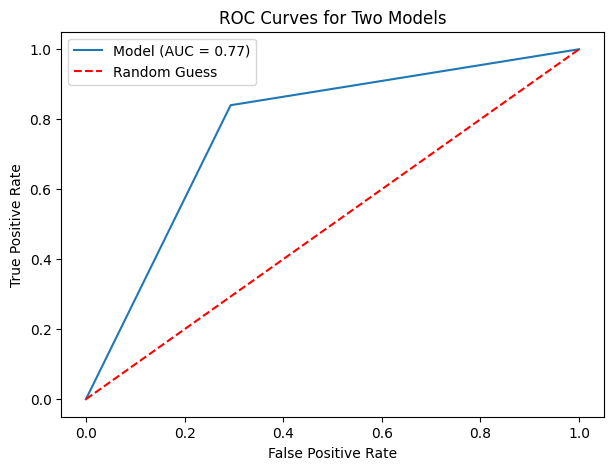

In [21]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [22]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction                          # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.7783
Recall:    0.7733
F1 Score:  0.7723
OA:        0.7733
AA:        0.7733


In [23]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [24]:
import json
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/LR {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'correct_0': 47, 'correct_1': 29, 'correct_total': 76, 'total': 100}, {'dataset': 1, 'correct_0': 16, 'correct_1': 50, 'correct_total': 66, 'total': 100}, {'dataset': 2, 'correct_0': 43, 'correct_1': 47, 'correct_total': 90, 'total': 100}, {'dataset': 'Total Dataset', 'correct_0': 106, 'correct_1': 126, 'correct_total': 232, 'total': 300}], 'performance': {'AUC': 0.7733333333333332, 'precision': 0.7782805429864253, 'recall': 0.7733333333333333, 'F1 Score': 0.7723214285714286, 'OA': 0.7733333333333333, 'AA': 0.7733333333333333}}
JSON saved to results.json


In [25]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

Run time: 11.5067 seconds


In [ ]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt

In [30]:
def predict_batch_whole(model, feature_extractor, batch_input, device):
    with torch.no_grad():  # Disable gradient computation
        test_features = feature_extractor(batch_input)  # shape: (10, 128)
        test_features_np = test_features.numpy()     # convert to NumPy

    # --- Predict continuous values ---
    predicted_values = model.predict(test_features_np)

    # --- Convert to class labels using threshold ---
    predicted_classes = (predicted_values >= 0.5).astype(int)

    # --- Clip predicted values to [0, 1] as pseudo-probabilities ---
    positive_probs = np.clip(predicted_values, 0, 1)


    return predicted_classes, positive_probs
   

In [26]:
from torch.utils.data import Dataset, DataLoader


class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [33]:


score = []
patch_size = 9
half_patch = patch_size // 2

data_sampler = None
batch_size = 64

correct0 = 0
correct1 = 0
matrix = []
gt = []
expected_patch_shape = []
dataset_patches = []
data_loader = []
patch_tensor = []
true_label = [] 
x = []
y = []
pred_matrix = []

matrix, gt = testWithWholeDataset(dataset)


expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)


patch_tensor, true_label, x, y = next(iter(data_loader))

print(patch_tensor.size())
print(true_label.size())
print(f"data loader size: {len(data_loader)}")

pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
correct = 0

for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


    preds, confs = predict_batch_whole(pipeline, feature_extractor, input_batch, device)

  
    label_batch = label_batch.numpy()
    x_batch = x_batch.numpy()
    y_batch = y_batch.numpy()

    for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
        pred_matrix[x - half_patch, y - half_patch] = pred
        if pred == label:
            if label == 0:
                correct0 += 1
            elif label == 1:
                correct1 += 1
            
correct = correct0+correct1
print(f"correct0 = {correct0}")
print(f"correct1 = {correct1}")
total = gt.shape[0] * gt.shape[1]
print(f"Score: {correct}/{total}")

# Save prediction matrix
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
np.save(f"prediction_matrix_dataset{dataset} LR {timestamp}.npy", pred_matrix)

img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [16:58<00:00, 19.16it/s]

correct0 = 547859
correct1 = 12142
Score: 560001/1248414


In [ ]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{total/2}\t', f'{correct1}/{total/2}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1


print(f"total: \t\t {all_correct0}/{all_total/2} \t {all_correct1}/{all_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [ ]:
groundtruths = groundtruth
groundtruth = []

for x in groundtruths:
    for y in x:
        groundtruth.append(y)

predictions = prediction
prediction = []

for x in predictions:
    for y in x:
        prediction.append(y)


y_prob = []

for x in y_probs:
    for y in x:
        y_prob.append(y)

In [ ]:
print(len(groundtruth))
print(len(prediction))
print(len(y_prob))

In [ ]:
y_test = groundtruth
y_pred = prediction
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

In [ ]:
print(f'{correct}/{total}')

In [ ]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

In [ ]:


test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [ ]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction                          # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

In [ ]:

performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [ ]:
import json
from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/LR {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

In [ ]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")